<a href="https://colab.research.google.com/github/viniventur/previsao_artigo_HW_SARIMA/blob/main/holt_winters_artigo_hw_sarima_anpec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudo de previsão de receitas utilizando suavização exponencial para os ICMS e IPVA
## Combinações: Aditivo e Multiplicativo e com tendência amortecida (damped trend)

## Baixando pacotes

In [2]:
# Pacotes de gerenciamento do sistema operacional, como manipulação de arquivos e diretórios, gerenciamento de processos, obtenção de informações do sistema, etc.
import os
from google.colab import drive
drive.mount('/content/drive')

# Pacotes para manipulação e tratamento de dados
import numpy as np
import pandas as pd
from datetime import datetime

# Pacotes para análise gráfica
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.dates import YearLocator
from matplotlib.font_manager import FontProperties
import matplotlib as mpl
import matplotlib.ticker as mticker
from matplotlib import font_manager
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

# Pacotes para análise econométrica
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# ES e Holt-Winters
from statsmodels.tsa.api import SimpleExpSmoothing,Holt,ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from statsmodels.tsa.seasonal import seasonal_decompose

Mounted at /content/drive


In [3]:
def previsao_hw(nome , df_completo, inicial_treino, limite_treino, periodos_season, numero_previsao):

  '''
  A função a seguir roda todos os 4 modelos (add e mult na sazonalidade e tendência) para o dataframe fornecido de acordo com os parâmetros abaixo:

  Argumentos:

  1. nome (str): Nome da previsão
  2. df_completo (var): Dataframe com todos os dados
  3. inicial_treino (str ou datatime): Data inicial dos dados de treino no formato YYYY-MM-DD
  4. limite_treino (str ou datatime): Data limite dos dados de treino no formato YYYY-MM-DD
  5. periodos_season (int): Períodos referentes a sazonalidade
  6. numero_previsao (int): Número de observações a serem previstas

  Retorno:

  Lista com os nomes das variáveis criadas para a previsão de cada modelo específico e as variáveis dos modelos individualmente contendo os dados concatenados (treino e previsto).
  '''

  # Ajustando a base de treino e real
  df_treino = df_completo.loc[(df_completo.index >= inicial_treino) & (df_completo.index <= limite_treino)]
  df_real = df_completo.loc[(df_completo.index > limite_treino)]
  df_prev_1 = pd.DataFrame(df_treino) # transformando em df caso apenas uma serie seja retornada

  # Realizando a previsão

  # Para realizar previsão de diferentes modelos dos que já estão listados aqui adicione mais itens no dict
  # Ordem: Tendência, Sazonalidade, Damped (bool)

  modelos_dic = {'prev_aa': ['add', 'add', False],
                 'prev_am': ['add', 'mul', False],
                 'prev_mm': ['mul', 'mul', False],
                 'prev_ma': ['mul', 'add', False],
                 'prev_aa_damp': ['add', 'add', True],
                 'prev_am_damp': ['add', 'mul', True],
                 'prev_mm_damp': ['mul', 'mul', True],
                 'prev_ma_damp': ['mul', 'add', True]
                 }

  for i in df_prev_1.columns:

    for nome_df, modelos in modelos_dic.items():

      modelo = ExponentialSmoothing(
                                df_prev_1[i],
                                seasonal_periods=periodos_season,
                                trend=modelos[0],
                                seasonal=modelos[1],
                                damped_trend=modelos[2]
                                ).fit()
      globals()[nome + "_mod_" + nome_df] = modelo
      previsao = modelo.forecast(numero_previsao)
      df_prev_2 = pd.concat([df_treino, previsao], axis=0)
      df_prev_2 = pd.DataFrame(df_prev_2, columns=df_prev_1.columns)
      globals()[nome + "_df_" + nome_df] = df_prev_2

  global lista_modelos
  global lista_df_prev
  lista_modelos = []
  lista_df_prev = []
  for i in modelos_dic.keys():
      lista_modelos.append(nome + "_mod_" + i)
      lista_df_prev.append(nome + "_df_" + i)

  def nomes(modelos_dic):
    print('Variaveis criadas: \n')
    print('Modelos: \n')
    print("lista_modelos \n")
    for i in modelos_dic.keys():
      print(nome + "_mod_" + i)
    print("\nDataframes com previsão: \n")
    print("lista_df_prev \n")
    for i in modelos_dic.keys():
      print(nome + "_df_" + i)

  return nomes(modelos_dic)

## Tratando dados

In [4]:
df = pd.read_excel("/content/drive/MyDrive/Gerência de Estudos e Projeções/Dados/Impostos/Impostos - ICMS - ITCD - IPVA - IRRF - 1999 - 2024.xlsx", sheet_name='dados_1999_2024')
#df = pd.read_excel("/content/drive/MyDrive/Gerência de Estudos e Projeções/Dados/Impostos/Bases de impostos antigas/bases_2008_2024 - VERSAO ULTRA MEGA MASTER FINAL.xlsx")
df['Total'] = df.ICMS + df.IPVA + df.IRRF + df.ITCD
df

,ANO,MES,ICMS,IPVA,ITCD,IRRF,Total
0,1999,1,4.035843e+07,658956.65,21163.97,3.293230e+03,4.104184e+07
1,1999,2,3.894808e+07,1032605.36,13089.30,8.150040e+03,4.000192e+07
2,1999,3,3.194334e+07,2489990.52,26279.08,0.000000e+00,3.445961e+07
3,1999,4,3.415198e+07,1851256.22,42705.30,0.000000e+00,3.604594e+07
4,1999,5,3.282836e+07,1905139.44,27892.99,0.000000e+00,3.476139e+07
...,...,...,...,...,...,...,...
302,2024,3,6.412978e+08,46837316.37,3990607.28,7.723583e+07,7.693616e+08
303,2024,4,6.901577e+08,64609203.08,4789282.70,8.712705e+07,8.466832e+08
304,2024,5,6.356771e+08,73725244.53,4528985.51,9.139155e+07,8.053229e+08
305,2024,6,6.307851e+08,71891371.15,5737256.86,1.084689e+08,8.168826e+08


In [5]:
# Limpando a base

df.dropna(inplace=True)
df['Data'] = pd.to_datetime(df['ANO'].astype(str) + '-' + df['MES'].astype(str))
df = df.set_index("Data")
df = df.drop(['MES', 'ANO'], axis=1)
df = df.loc[(df.index >= '2008-01-01') & (df.index <= '2023-12-01')] # inicio definido em 01-2008 e fim definido em 12-2023
df

,ICMS,IPVA,ITCD,IRRF,Total
Data,,,,,
2008-01-01,1.435041e+08,3089289.71,272955.72,4.840761e+05,1.473504e+08
2008-02-01,1.339496e+08,4518615.04,110671.20,8.355140e+06,1.469340e+08
2008-03-01,1.263094e+08,6134471.17,215239.97,1.906390e+07,1.517230e+08
2008-04-01,1.245758e+08,8201420.84,207046.89,1.104372e+07,1.440280e+08
2008-05-01,1.288502e+08,8670808.35,239724.30,1.093729e+07,1.486980e+08
...,...,...,...,...,...
2023-08-01,5.578557e+08,56001603.14,4855889.47,5.354547e+07,6.722587e+08
2023-09-01,5.642487e+08,41140989.16,3953284.60,9.360826e+07,7.029513e+08
2023-10-01,5.865288e+08,37133784.15,5590517.01,7.255622e+07,7.018094e+08


In [6]:
# Utilizando apenas ICMS e IPVA
df = df[['ICMS', 'IPVA']]
df

,ICMS,IPVA
Data,,
2008-01-01,1.435041e+08,3089289.71
2008-02-01,1.339496e+08,4518615.04
2008-03-01,1.263094e+08,6134471.17
2008-04-01,1.245758e+08,8201420.84
2008-05-01,1.288502e+08,8670808.35
...,...,...
2023-08-01,5.578557e+08,56001603.14
2023-09-01,5.642487e+08,41140989.16
2023-10-01,5.865288e+08,37133784.15


In [7]:
sumario = df.describe().round(2)
sumario

,ICMS,IPVA
count,1.920000e+02,192.00
mean,3.002499e+08,22440627.49
std,1.266281e+08,16823854.89
min,1.191132e+08,2810935.45
25%,2.005117e+08,9609944.80
50%,2.817541e+08,16583324.78
75%,3.678602e+08,32496373.63
max,8.145125e+08,87731781.40


In [8]:
cvs = pd.DataFrame(index=['CV'], columns=['ICMS', 'IPVA'])
cvs['ICMS'] = (sumario.iloc[2,0]/sumario.iloc[1,0])*100
cvs['IPVA'] = (sumario.iloc[2,1]/sumario.iloc[1,1])*100
cvs

,ICMS,IPVA
CV,42.174225,74.970519


In [9]:
sumario = pd.concat([sumario, cvs], axis=0)
sumario

,ICMS,IPVA
count,1.920000e+02,1.920000e+02
mean,3.002499e+08,2.244063e+07
std,1.266281e+08,1.682385e+07
min,1.191132e+08,2.810935e+06
25%,2.005117e+08,9.609945e+06
50%,2.817541e+08,1.658332e+07
75%,3.678602e+08,3.249637e+07
max,8.145125e+08,8.773178e+07
CV,4.217422e+01,7.497052e+01


In [10]:
sumario.to_excel('/content/drive/MyDrive/Gerência de Estudos e Projeções/ARTIGOS/Artigo HOLT-SARIMA/Resultados/Sumario_descritivo.xlsx')

In [11]:
# treino e real
df_treino = df.loc[(df.index >= '2008-01-01') & (df.index <= '2022-08-01')]
df_real = df.loc[(df.index >= '2022-09-01')]

## Rodando a previsão para 16 meses após agosto de 2022 (final do ano de 2022 + 2023)

In [12]:
for col in df.columns:
  previsao_hw(col, df[col], df.index.min(), '2022-08-01', 12, 16)

Variaveis criadas: 

Modelos: 

lista_modelos 

ICMS_mod_prev_aa
ICMS_mod_prev_am
ICMS_mod_prev_mm
ICMS_mod_prev_ma
ICMS_mod_prev_aa_damp
ICMS_mod_prev_am_damp
ICMS_mod_prev_mm_damp
ICMS_mod_prev_ma_damp

Dataframes com previsão: 

lista_df_prev 

ICMS_df_prev_aa
ICMS_df_prev_am
ICMS_df_prev_mm
ICMS_df_prev_ma
ICMS_df_prev_aa_damp
ICMS_df_prev_am_damp
ICMS_df_prev_mm_damp
ICMS_df_prev_ma_damp
Variaveis criadas: 

Modelos: 

lista_modelos 

IPVA_mod_prev_aa
IPVA_mod_prev_am
IPVA_mod_prev_mm
IPVA_mod_prev_ma
IPVA_mod_prev_aa_damp
IPVA_mod_prev_am_damp
IPVA_mod_prev_mm_damp
IPVA_mod_prev_ma_damp

Dataframes com previsão: 

lista_df_prev 

IPVA_df_prev_aa
IPVA_df_prev_am
IPVA_df_prev_mm
IPVA_df_prev_ma
IPVA_df_prev_aa_damp
IPVA_df_prev_am_damp
IPVA_df_prev_mm_damp
IPVA_df_prev_ma_damp


## Avaliando melhor modelo

### ICMS

In [13]:
data_ini_prev = '2022-09-01'
df_real = df['ICMS']
df_real = df_real.loc[(df_real.index >= data_ini_prev) & (df_real.index <= '2023-12-01')]

dfs_prev = [ICMS_df_prev_aa,
            ICMS_df_prev_am,
            ICMS_df_prev_mm,
            ICMS_df_prev_ma,
            ICMS_df_prev_aa_damp,
            ICMS_df_prev_am_damp,
            ICMS_df_prev_mm_damp,
            ICMS_df_prev_ma_damp]

mods = [ICMS_mod_prev_aa,
        ICMS_mod_prev_am,
        ICMS_mod_prev_mm,
        ICMS_mod_prev_ma,
        ICMS_mod_prev_aa_damp,
        ICMS_mod_prev_am_damp,
        ICMS_mod_prev_mm_damp,
        ICMS_mod_prev_ma_damp]

df_error = pd.DataFrame(index=['AA','AM', 'MM', 'MA', 'AAD','AMD', 'MMD', 'MAD'],
                        columns=['MAPE', 'MAE', 'RMSE', 'AIC', 'BIC'])

for lin, dfs_prev, mods in zip(range(0,10), dfs_prev, mods):
  df_error.iloc[lin, 0] = round(MAPE(df_real,
                                     dfs_prev.loc[(dfs_prev.index >= data_ini_prev)])*100,
                                2)
  df_error.iloc[lin, 1] = round(MAE(df_real,
                                    dfs_prev.loc[(dfs_prev.index >= data_ini_prev)]),
                                2)
  df_error.iloc[lin, 2] = round(MSE(df_real,
                                    dfs_prev.loc[(dfs_prev.index >= data_ini_prev)],
                                    squared=False),2)
  df_error.iloc[lin, 3] = round(mods.aic,2)
  df_error.iloc[lin, 4] = round(mods.bic,2)
df_error.sort_values(by='MAPE', inplace=True)
df_error_icms = df_error
df_error_icms

,MAPE,MAE,RMSE,AIC,BIC
AA,8.4,50283953.67,69646963.13,6046.59,6097.32
MA,8.46,50722347.06,70463623.15,6044.35,6095.08
MAD,8.71,52623971.6,75030631.85,6050.02,6103.91
MM,9.16,54145071.65,70164490.67,6034.81,6085.54
AAD,9.34,56248762.59,78669325.98,6049.88,6103.78
AMD,10.02,59547972.79,77944805.34,6039.79,6093.68
MMD,10.9,65055353.99,86284693.81,6039.45,6093.34
AM,11.23,66995449.12,88685215.71,6036.54,6087.27


### IPVA

In [14]:
data_ini_prev = '2022-09-01'
df_real = df['IPVA']
df_real = df_real.loc[(df_real.index >= data_ini_prev) & (df_real.index <= '2023-12-01')]

dfs_prev = [IPVA_df_prev_aa,
            IPVA_df_prev_am,
            IPVA_df_prev_mm,
            IPVA_df_prev_ma,
            IPVA_df_prev_aa_damp,
            IPVA_df_prev_am_damp,
            IPVA_df_prev_mm_damp,
            IPVA_df_prev_ma_damp]

mods = [IPVA_mod_prev_aa,
        IPVA_mod_prev_am,
        IPVA_mod_prev_mm,
        IPVA_mod_prev_ma,
        IPVA_mod_prev_aa_damp,
        IPVA_mod_prev_am_damp,
        IPVA_mod_prev_mm_damp,
        IPVA_mod_prev_ma_damp]

df_error = pd.DataFrame(index=['AA','AM', 'MM', 'MA', 'AAD','AMD', 'MMD', 'MAD'],
                        columns=['MAPE', 'MAE', 'RMSE', 'AIC', 'BIC'])

for lin, dfs_prev, mods in zip(range(0,10), dfs_prev, mods):
  df_error.iloc[lin, 0] = round(MAPE(df_real,
                                     dfs_prev.loc[(dfs_prev.index >= data_ini_prev)])*100,
                                2)
  df_error.iloc[lin, 1] = round(MAE(df_real,
                                    dfs_prev.loc[(dfs_prev.index >= data_ini_prev)]),
                                2)
  df_error.iloc[lin, 2] = round(MSE(df_real,
                                    dfs_prev.loc[(dfs_prev.index >= data_ini_prev)],
                                    squared=False),2)
  df_error.iloc[lin, 3] = round(mods.aic,2)
  df_error.iloc[lin, 4] = round(mods.bic,2)
df_error.sort_values(by='MAPE', inplace=True)
df_error_ipva = df_error
df_error_ipva

,MAPE,MAE,RMSE,AIC,BIC
MM,10.59,4329844.89,5054042.41,5582.06,5632.79
MAD,11.18,5710299.34,7724588.3,5562.4,5616.3
AA,11.23,5670889.89,7619102.5,5559.47,5610.2
AAD,11.54,6062627.99,8352201.83,5564.84,5618.74
MA,13.03,5178005.39,6169894.32,5556.03,5606.76
MMD,21.5,9007058.35,10447949.84,5572.34,5626.24
AM,21.64,9065255.41,10504087.56,5567.92,5618.65
AMD,24.84,10436828.08,11931880.05,5576.47,5630.37


In [15]:
df_error_icms.to_excel('/content/drive/MyDrive/Gerência de Estudos e Projeções/ARTIGOS/Artigo HOLT-SARIMA/Resultados/df_error_icms.xlsx')
df_error_ipva.to_excel('/content/drive/MyDrive/Gerência de Estudos e Projeções/ARTIGOS/Artigo HOLT-SARIMA/Resultados/df_error_ipva.xlsx')

### Analisando os coeficientes dos melhores modelos

In [16]:
print(ICMS_mod_prev_aa.summary())

                         ExponentialSmoothing Model Results                         
Dep. Variable:                     ICMS   No. Observations:                      176
Model:             ExponentialSmoothing   SSE                 122181546689824736.000
Optimized:                         True   AIC                               6046.589
Trend:                         Additive   BIC                               6097.317
Seasonal:                      Additive   AICC                              6050.946
Seasonal Periods:                    12   Date:                     Thu, 18 Jul 2024
Box-Cox:                          False   Time:                             15:55:05
Box-Cox Coeff.:                    None                                             
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2878571                alpha           

In [17]:
print(IPVA_mod_prev_mm.summary())

                        ExponentialSmoothing Model Results                        
Dep. Variable:                     IPVA   No. Observations:                    176
Model:             ExponentialSmoothing   SSE                 8724760288252058.000
Optimized:                         True   AIC                             5582.065
Trend:                   Multiplicative   BIC                             5632.792
Seasonal:                Multiplicative   AICC                            5586.421
Seasonal Periods:                    12   Date:                   Thu, 18 Jul 2024
Box-Cox:                          False   Time:                           15:55:05
Box-Cox Coeff.:                    None                                           
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0050000                alpha                 True
smoothi

### Exportando os melhores modelos

In [18]:
# Valores
ICMS_df_prev_aa.to_excel('/content/drive/MyDrive/Gerência de Estudos e Projeções/ARTIGOS/Artigo HOLT-SARIMA/Resultados/ICMS_df_prev_aa.xlsx')
IPVA_df_prev_mm.to_excel('/content/drive/MyDrive/Gerência de Estudos e Projeções/ARTIGOS/Artigo HOLT-SARIMA/Resultados/ICMS_df_prev_mm.xlsx')
# Sumários
df_summary_icms = pd.read_html(ICMS_mod_prev_aa.summary().tables[1].as_html(), header=0, index_col=0)[0]
df_summary_icms.to_excel('/content/drive/MyDrive/Gerência de Estudos e Projeções/ARTIGOS/Artigo HOLT-SARIMA/Resultados/df_summary_icms.xlsx')
df_summary_ipva = pd.read_html(IPVA_mod_prev_mm.summary().tables[1].as_html(), header=0, index_col=0)[0]
df_summary_ipva.to_excel('/content/drive/MyDrive/Gerência de Estudos e Projeções/ARTIGOS/Artigo HOLT-SARIMA/Resultados/df_summary_ipva.xlsx')

# Analisando intervalos de confiança e intervalos de previsão

In [19]:
df

,ICMS,IPVA
Data,,
2008-01-01,1.435041e+08,3089289.71
2008-02-01,1.339496e+08,4518615.04
2008-03-01,1.263094e+08,6134471.17
2008-04-01,1.245758e+08,8201420.84
2008-05-01,1.288502e+08,8670808.35
...,...,...
2023-08-01,5.578557e+08,56001603.14
2023-09-01,5.642487e+08,41140989.16
2023-10-01,5.865288e+08,37133784.15


In [20]:
df_prev_real_icms = pd.DataFrame(df['ICMS'].loc[(df.index >= '2022-09-01') & (df.index <= '2023-12-01')].copy())
df_prev_real_icms['Previsao'] = ICMS_df_prev_aa.loc[(ICMS_df_prev_aa.index >= '2022-09-01') & (ICMS_df_prev_aa.index <= '2023-12-01')].copy()
df_prev_real_icms.rename(columns={'ICMS': 'Real'}, inplace=True)
df_prev_real_icms

,Real,Previsao
Data,,
2022-09-01,4.516591e+08,4.838527e+08
2022-10-01,4.914448e+08,5.055006e+08
2022-11-01,5.007574e+08,5.232216e+08
2022-12-01,5.177060e+08,5.600016e+08
2023-01-01,5.190866e+08,5.397366e+08
2023-02-01,4.914509e+08,5.030527e+08
2023-03-01,4.920383e+08,4.697675e+08
2023-04-01,5.240503e+08,4.981110e+08
2023-05-01,5.369862e+08,4.812650e+08


In [21]:
df_prev_real_ipva = pd.DataFrame(df['IPVA'].loc[(df.index >= '2022-09-01') & (df.index <= '2023-12-01')].copy())
df_prev_real_ipva['Previsao'] = IPVA_df_prev_mm.loc[(IPVA_df_prev_mm.index >= '2022-09-01') & (IPVA_df_prev_mm.index <= '2023-12-01')].copy()
df_prev_real_ipva.rename(columns={'IPVA': 'Real'}, inplace=True)
df_prev_real_ipva

,Real,Previsao
Data,,
2022-09-01,34581089.82,3.051273e+07
2022-10-01,28019444.36,2.376226e+07
2022-11-01,19444161.37,1.934753e+07
2022-12-01,16460877.34,1.358945e+07
2023-01-01,87731781.40,8.166238e+07
2023-02-01,38299782.86,3.874454e+07
2023-03-01,53108739.12,5.855931e+07
2023-04-01,51508904.49,5.709886e+07
2023-05-01,75214488.41,7.295406e+07


### Formula para o intervalo de confiança:

$$CI = \overline{X} \pm  Z \times (\frac{\sigma}{\sqrt{n}})$$

### Formula para o intervalo de previsão:

$$PI = \overline{X} \pm  Z \times {\sigma} \times \sqrt{1 + (\frac{1}{n}})$$

In [22]:
# ICMS

# Utilizando z-score de distribuição normal
n = len(df_prev_real_icms)
df_prev_real_icms['error'] = df_prev_real_icms['Real'] - df_prev_real_icms['Previsao']
s = df_prev_real_icms['error'].std(ddof=1)

df_prev_real_icms['conf_interval'] = 1.96 * s / np.sqrt(n)
df_prev_real_icms['pred_interval'] = 1.96 * s * np.sqrt(1 + 1/n)

# Calculando limites superiores e inferiores para cada previsão
df_prev_real_icms['conf_lower'] = df_prev_real_icms['Previsao'] - df_prev_real_icms['conf_interval']
df_prev_real_icms['conf_upper'] = df_prev_real_icms['Previsao'] + df_prev_real_icms['conf_interval']
df_prev_real_icms['pred_lower'] = df_prev_real_icms['Previsao'] - df_prev_real_icms['pred_interval']
df_prev_real_icms['pred_upper'] = df_prev_real_icms['Previsao'] + df_prev_real_icms['pred_interval']
df_prev_real_icms

,Real,Previsao,error,conf_interval,pred_interval,conf_lower,conf_upper,pred_lower,pred_upper
Data,,,,,,,,,
2022-09-01,4.516591e+08,4.838527e+08,-3.219365e+07,3.120639e+07,1.286672e+08,4.526463e+08,5.150591e+08,3.551855e+08,6.125200e+08
2022-10-01,4.914448e+08,5.055006e+08,-1.405580e+07,3.120639e+07,1.286672e+08,4.742942e+08,5.367070e+08,3.768334e+08,6.341679e+08
2022-11-01,5.007574e+08,5.232216e+08,-2.246414e+07,3.120639e+07,1.286672e+08,4.920152e+08,5.544280e+08,3.945543e+08,6.518888e+08
2022-12-01,5.177060e+08,5.600016e+08,-4.229561e+07,3.120639e+07,1.286672e+08,5.287952e+08,5.912080e+08,4.313343e+08,6.886688e+08
2023-01-01,5.190866e+08,5.397366e+08,-2.065006e+07,3.120639e+07,1.286672e+08,5.085302e+08,5.709430e+08,4.110694e+08,6.684039e+08
2023-02-01,4.914509e+08,5.030527e+08,-1.160179e+07,3.120639e+07,1.286672e+08,4.718463e+08,5.342591e+08,3.743854e+08,6.317199e+08
2023-03-01,4.920383e+08,4.697675e+08,2.227080e+07,3.120639e+07,1.286672e+08,4.385611e+08,5.009739e+08,3.411002e+08,5.984347e+08
2023-04-01,5.240503e+08,4.981110e+08,2.593934e+07,3.120639e+07,1.286672e+08,4.669046e+08,5.293174e+08,3.694438e+08,6.267782e+08
2023-05-01,5.369862e+08,4.812650e+08,5.572118e+07,3.120639e+07,1.286672e+08,4.500586e+08,5.124714e+08,3.525978e+08,6.099323e+08


In [23]:
# IPVA

# Utilizando z-score de distribuição normal
n = len(df_prev_real_ipva)
df_prev_real_ipva['error'] = df_prev_real_ipva['Real'] - df_prev_real_ipva['Previsao']
s = df_prev_real_ipva['error'].std(ddof=1)

df_prev_real_ipva['conf_interval'] = 1.96 * s / np.sqrt(n)
df_prev_real_ipva['pred_interval'] = 1.96 * s * np.sqrt(1 + 1/n)

# Calculando limites superiores e inferiores para cada previsão
df_prev_real_ipva['conf_lower'] = df_prev_real_ipva['Previsao'] - df_prev_real_ipva['conf_interval']
df_prev_real_ipva['conf_upper'] = df_prev_real_ipva['Previsao'] + df_prev_real_ipva['conf_interval']
df_prev_real_ipva['pred_lower'] = df_prev_real_ipva['Previsao'] - df_prev_real_ipva['pred_interval']
df_prev_real_ipva['pred_upper'] = df_prev_real_ipva['Previsao'] + df_prev_real_ipva['pred_interval']
df_prev_real_ipva

,Real,Previsao,error,conf_interval,pred_interval,conf_lower,conf_upper,pred_lower,pred_upper
Data,,,,,,,,,
2022-09-01,34581089.82,3.051273e+07,4.068356e+06,2.096806e+06,8.645351e+06,2.841593e+07,3.260954e+07,2.186738e+07,3.915809e+07
2022-10-01,28019444.36,2.376226e+07,4.257188e+06,2.096806e+06,8.645351e+06,2.166545e+07,2.585906e+07,1.511691e+07,3.240761e+07
2022-11-01,19444161.37,1.934753e+07,9.662828e+04,2.096806e+06,8.645351e+06,1.725073e+07,2.144434e+07,1.070218e+07,2.799288e+07
2022-12-01,16460877.34,1.358945e+07,2.871424e+06,2.096806e+06,8.645351e+06,1.149265e+07,1.568626e+07,4.944102e+06,2.223480e+07
2023-01-01,87731781.40,8.166238e+07,6.069402e+06,2.096806e+06,8.645351e+06,7.956557e+07,8.375918e+07,7.301703e+07,9.030773e+07
2023-02-01,38299782.86,3.874454e+07,-4.447570e+05,2.096806e+06,8.645351e+06,3.664773e+07,4.084135e+07,3.009919e+07,4.738989e+07
2023-03-01,53108739.12,5.855931e+07,-5.450572e+06,2.096806e+06,8.645351e+06,5.646251e+07,6.065612e+07,4.991396e+07,6.720466e+07
2023-04-01,51508904.49,5.709886e+07,-5.589955e+06,2.096806e+06,8.645351e+06,5.500205e+07,5.919566e+07,4.845351e+07,6.574421e+07
2023-05-01,75214488.41,7.295406e+07,2.260430e+06,2.096806e+06,8.645351e+06,7.085725e+07,7.505086e+07,6.430871e+07,8.159941e+07


#### Opção com t de student

In [24]:
# ICMS

# Utilizando T de student para os intervalos
n = len(df_prev_real_icms)
df_prev_real_icms['error'] = df_prev_real_icms['Real'] - df_prev_real_icms['Previsao']
s = df_prev_real_icms['error'].std(ddof=1)
t = stats.t.ppf(0.975, df=n-1)

df_prev_real_icms['conf_interval'] = t  * s / np.sqrt(n)
df_prev_real_icms['pred_interval'] = t  * s * np.sqrt(1 + (1/n))

# Calculando limites superiores e inferiores para cada previsão
df_prev_real_icms['conf_lower'] = df_prev_real_icms['Previsao'] - df_prev_real_icms['conf_interval']
df_prev_real_icms['conf_upper'] = df_prev_real_icms['Previsao'] + df_prev_real_icms['conf_interval']
df_prev_real_icms['pred_lower'] = df_prev_real_icms['Previsao'] - df_prev_real_icms['pred_interval']
df_prev_real_icms['pred_upper'] = df_prev_real_icms['Previsao'] + df_prev_real_icms['pred_interval']
df_prev_real_icms

,Real,Previsao,error,conf_interval,pred_interval,conf_lower,conf_upper,pred_lower,pred_upper
Data,,,,,,,,,
2022-09-01,4.516591e+08,4.838527e+08,-3.219365e+07,3.393615e+07,1.399223e+08,4.499166e+08,5.177889e+08,3.439304e+08,6.237750e+08
2022-10-01,4.914448e+08,5.055006e+08,-1.405580e+07,3.393615e+07,1.399223e+08,4.715645e+08,5.394368e+08,3.655783e+08,6.454229e+08
2022-11-01,5.007574e+08,5.232216e+08,-2.246414e+07,3.393615e+07,1.399223e+08,4.892854e+08,5.571577e+08,3.832993e+08,6.631439e+08
2022-12-01,5.177060e+08,5.600016e+08,-4.229561e+07,3.393615e+07,1.399223e+08,5.260654e+08,5.939377e+08,4.200793e+08,6.999239e+08
2023-01-01,5.190866e+08,5.397366e+08,-2.065006e+07,3.393615e+07,1.399223e+08,5.058005e+08,5.736728e+08,3.998143e+08,6.796589e+08
2023-02-01,4.914509e+08,5.030527e+08,-1.160179e+07,3.393615e+07,1.399223e+08,4.691165e+08,5.369888e+08,3.631304e+08,6.429750e+08
2023-03-01,4.920383e+08,4.697675e+08,2.227080e+07,3.393615e+07,1.399223e+08,4.358313e+08,5.037036e+08,3.298452e+08,6.096898e+08
2023-04-01,5.240503e+08,4.981110e+08,2.593934e+07,3.393615e+07,1.399223e+08,4.641748e+08,5.320471e+08,3.581887e+08,6.380333e+08
2023-05-01,5.369862e+08,4.812650e+08,5.572118e+07,3.393615e+07,1.399223e+08,4.473289e+08,5.152012e+08,3.413427e+08,6.211873e+08


In [25]:
# IPVA

# Utilizando T de student para os intervalos
n = len(df_prev_real_ipva)
df_prev_real_ipva['error'] = df_prev_real_ipva['Real'] - df_prev_real_ipva['Previsao']
s = df_prev_real_ipva['error'].std(ddof=1)
t = stats.t.ppf(0.975, df=n-1)

df_prev_real_ipva['conf_interval'] = t  * s / np.sqrt(n)
df_prev_real_ipva['pred_interval'] = t  * s * np.sqrt(1 + (1/n))

# Calculando limites superiores e inferiores para cada previsão
df_prev_real_ipva['conf_lower'] = df_prev_real_ipva['Previsao'] - df_prev_real_ipva['conf_interval']
df_prev_real_ipva['conf_upper'] = df_prev_real_ipva['Previsao'] + df_prev_real_ipva['conf_interval']
df_prev_real_ipva['pred_lower'] = df_prev_real_ipva['Previsao'] - df_prev_real_ipva['pred_interval']
df_prev_real_ipva['pred_upper'] = df_prev_real_ipva['Previsao'] + df_prev_real_ipva['pred_interval']
df_prev_real_ipva

,Real,Previsao,error,conf_interval,pred_interval,conf_lower,conf_upper,pred_lower,pred_upper
Data,,,,,,,,,
2022-09-01,34581089.82,3.051273e+07,4.068356e+06,2.280222e+06,9.401597e+06,2.823251e+07,3.279296e+07,2.111114e+07,3.991433e+07
2022-10-01,28019444.36,2.376226e+07,4.257188e+06,2.280222e+06,9.401597e+06,2.148203e+07,2.604248e+07,1.436066e+07,3.316385e+07
2022-11-01,19444161.37,1.934753e+07,9.662828e+04,2.280222e+06,9.401597e+06,1.706731e+07,2.162776e+07,9.945936e+06,2.874913e+07
2022-12-01,16460877.34,1.358945e+07,2.871424e+06,2.280222e+06,9.401597e+06,1.130923e+07,1.586968e+07,4.187856e+06,2.299105e+07
2023-01-01,87731781.40,8.166238e+07,6.069402e+06,2.280222e+06,9.401597e+06,7.938216e+07,8.394260e+07,7.226078e+07,9.106398e+07
2023-02-01,38299782.86,3.874454e+07,-4.447570e+05,2.280222e+06,9.401597e+06,3.646432e+07,4.102476e+07,2.934294e+07,4.814614e+07
2023-03-01,53108739.12,5.855931e+07,-5.450572e+06,2.280222e+06,9.401597e+06,5.627909e+07,6.083953e+07,4.915771e+07,6.796091e+07
2023-04-01,51508904.49,5.709886e+07,-5.589955e+06,2.280222e+06,9.401597e+06,5.481864e+07,5.937908e+07,4.769726e+07,6.650046e+07
2023-05-01,75214488.41,7.295406e+07,2.260430e+06,2.280222e+06,9.401597e+06,7.067384e+07,7.523428e+07,6.355246e+07,8.235566e+07


In [26]:
# Exportando
df_prev_real_icms.to_excel('/content/drive/MyDrive/Gerência de Estudos e Projeções/ARTIGOS/Artigo HOLT-SARIMA/Resultados/df_prev_real_icms.xlsx')
df_prev_real_ipva.to_excel('/content/drive/MyDrive/Gerência de Estudos e Projeções/ARTIGOS/Artigo HOLT-SARIMA/Resultados/df_prev_real_ipva.xlsx')

# Visualizando

## Configurando a fonte utilizada: Times New Roman

In [27]:
# Fontes disponíveis
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

In [28]:
# Adicionando Times new Roman
font_dirs = ["/content/drive/MyDrive/Gerência de Estudos e Projeções/ARTIGOS/Artigo HOLT-SARIMA/Fontes"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [29]:
# Fontes disponíveis
def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

In [40]:
# Definindo timew new roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14

## Visualização com médias móveis

In [31]:
df_mm = df.copy()
for i in [6, 12]:
  for j in ['ICMS', 'IPVA']:
   df_mm[f'MM {i} - {j}'] = df_mm[j].rolling(i).mean()
df_mm.dropna(inplace=True)
df_mm

,ICMS,IPVA,MM 6 - ICMS,MM 6 - IPVA,MM 12 - ICMS,MM 12 - IPVA
Data,,,,,,
2008-12-01,1.870634e+08,2929893.99,1.457239e+08,8.229485e+06,1.375538e+08,7.420653e+06
2009-01-01,1.537090e+08,2810935.45,1.493781e+08,7.173771e+06,1.384042e+08,7.397457e+06
2009-02-01,1.406116e+08,6221179.41,1.503702e+08,5.576891e+06,1.389594e+08,7.539337e+06
2009-03-01,1.309832e+08,7423348.33,1.519977e+08,5.353430e+06,1.393489e+08,7.646744e+06
2009-04-01,1.406609e+08,9078172.40,1.508689e+08,5.501070e+06,1.406893e+08,7.719806e+06
...,...,...,...,...,...,...
2023-08-01,5.578557e+08,56001603.14,5.362222e+08,6.329400e+07,5.157865e+08,5.035843e+07
2023-09-01,5.642487e+08,41140989.16,5.482573e+08,6.129938e+07,5.251690e+08,5.090509e+07
2023-10-01,5.865288e+08,37133784.15,5.586703e+08,5.890352e+07,5.330926e+08,5.166462e+07


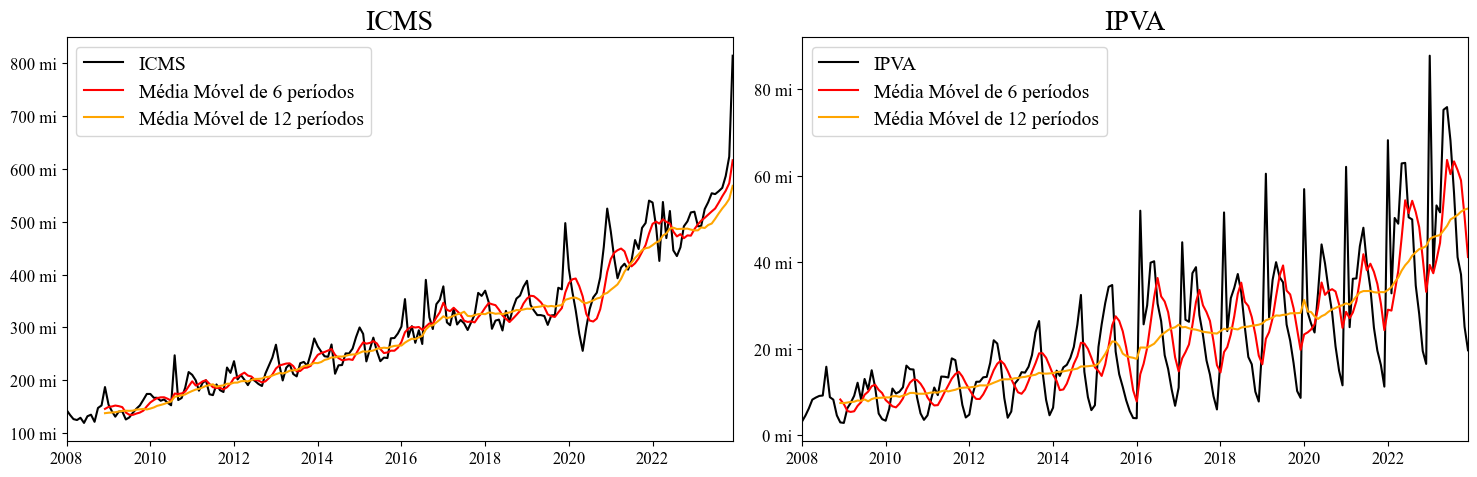

In [48]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Base de dados para os graficos
ini_treino = '2021-01-01'
fim_treino = '2022-08-01'
ini_prev = '2022-09-01'
fim_prev = '2023-12-01'
imp_ax = {'ICMS': ax1, 'IPVA': ax2}
cores_e_mm = {'red': 6, 'orange': 12}

for imp, axs in imp_ax.items():
  # Imposto
  sns.lineplot(x=df.loc[df.index <= fim_prev].index,
               y=df.loc[df.index <= fim_prev][imp],
               label=imp,
               color='black',
               ax=axs)
  # Médias móveis
  for c, i in cores_e_mm.items():
    sns.lineplot(x=df_mm.index,
                  y=df_mm[f'MM {i} - {imp}'],
                  color = c,
                  ax=axs,
                  linewidth=1.5,
                  label=f'Média Móvel de {i} períodos')

# Formatação
def formatar_milhares(x, pos):
  return f'{x/1000000:.0f} mi'
formatter = mticker.FuncFormatter(formatar_milhares)
year_locator = YearLocator(base=2)

for ax in (ax1, ax2):
  ax.xaxis.set_major_locator(year_locator)
  ax.yaxis.set_major_formatter(formatter)
  ax.set_xlabel('')
  ax.set_ylabel('')
  #ax.spines['top'].set_visible(False)
  #ax.spines['right'].set_visible(False)
  ax.set_xlim(min(df.index), max(df.loc[(df.index <= fim_prev)].index))
  ax.tick_params(axis='x', labelsize=12)
  ax.tick_params(axis='y', labelsize=12)
  ax.legend(loc='upper left')
ax1.set_title('ICMS', fontdict={'fontsize': 20})
ax2.set_title('IPVA', fontdict={'fontsize': 20})
plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/Gerência de Estudos e Projeções/ARTIGOS/Artigo HOLT-SARIMA/Resultados/graf_series_medmoveis.png', transparent=True, dpi=800)
plt.show()

## Pré-processamento

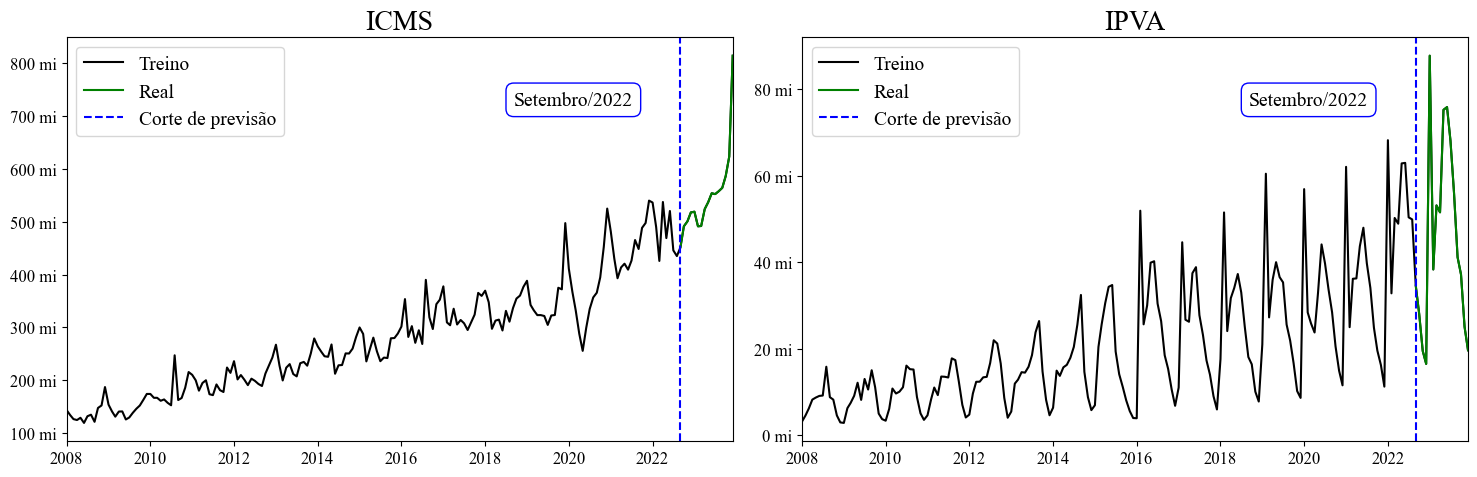

In [49]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Base de dados para os graficos
ini_treino = '2021-01-01'
fim_treino = '2022-08-01'
ini_prev = '2022-09-01'
fim_prev = '2023-12-01'
imp_ax = {'ICMS': ax1, 'IPVA': ax2}

for imp, axs in imp_ax.items():
  # Treino
  sns.lineplot(x=df.loc[df.index <= fim_prev].index,
               y=df.loc[df.index <= fim_prev][imp],
               label='Treino',
               color='black',
               ax=axs)
  # Real
  sns.lineplot(x=df.loc[(df.index >= ini_prev) & (df.index <= fim_prev)].index,
               y=df.loc[(df.index >= ini_prev) & (df.index <= fim_prev)][imp],
               label='Real',
               color='green',
               ax=axs)

# Formatação
def formatar_milhares(x, pos):
  return f'{x/1000000:.0f} mi'
formatter = mticker.FuncFormatter(formatar_milhares)
year_locator = YearLocator(base=2)

for ax in (ax1, ax2):
  ax.xaxis.set_major_locator(year_locator)
  ax.yaxis.set_major_formatter(formatter)
  ax.set_xlabel('')
  ax.set_ylabel('')
  #ax.spines['top'].set_visible(False)
  #ax.spines['right'].set_visible(False)
  ax.set_xlim(min(df.index), max(df.loc[(df.index <= fim_prev)].index))
  ax.tick_params(axis='x', labelsize=12)
  ax.tick_params(axis='y', labelsize=12)
  ax.axvline(x=pd.to_datetime('2022-09-01'), color='blue', linestyle='--', label='Corte de previsão')
  ax.annotate('Setembro/2022', xy=(pd.to_datetime('2022-09-01'), ax.get_ylim()[1]), xytext=(-120, -45),
              fontsize=14, textcoords='offset points', ha='left', va='center', color='black',
              bbox=dict(boxstyle='round,pad=0.4', edgecolor='blue', facecolor='white'))
  ax.legend(loc='upper left')
ax1.set_title('ICMS', fontdict={'fontsize': 20})
ax2.set_title('IPVA', fontdict={'fontsize': 20})
plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/Gerência de Estudos e Projeções/ARTIGOS/Artigo HOLT-SARIMA/Resultados/graf_treino_real2.png', transparent=True, dpi=800)
plt.show()

## Previsões

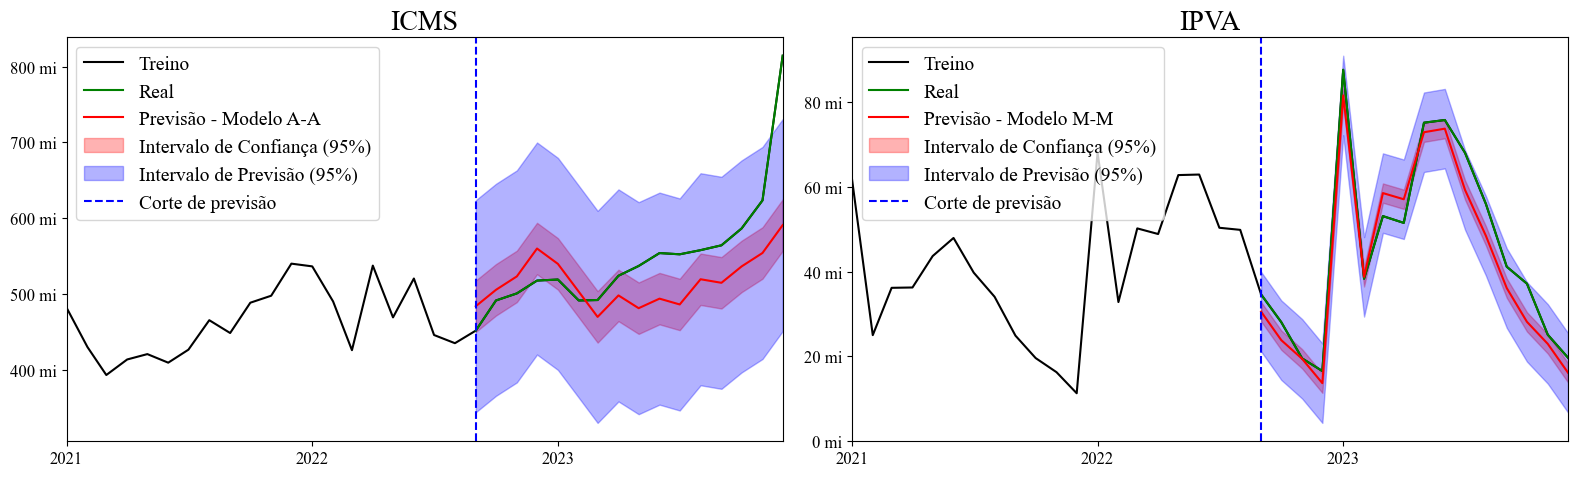

In [50]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Base de dados para os graficos
ini_treino = '2021-01-01'
fim_treino = '2022-08-01'
ini_prev = '2022-09-01'
fim_prev = '2023-12-01'
imp_ax = {'ICMS': [ax1, df_prev_real_icms, "A-A"], 'IPVA': [ax2, df_prev_real_ipva, "M-M"]}

for imp, axs in imp_ax.items():
  # Treino
  sns.lineplot(x=df.loc[(df.index >= ini_treino) & (df.index <= fim_prev)].index,
               y=df.loc[(df.index >= ini_treino) & (df.index <= fim_prev)][imp],
               label='Treino',
               color='black',
               ax=axs[0])
  # Real
  sns.lineplot(x=df.loc[(df.index >= ini_prev) & (df.index <= fim_prev)].index,
               y=df.loc[(df.index >= ini_prev) & (df.index <= fim_prev)][imp],
               label='Real',
               color='green',
               ax=axs[0])
  # Previsão
  sns.lineplot(x=axs[1].loc[(axs[1].index >= ini_prev) & (axs[1].index <= fim_prev)].index,
               y=axs[1].loc[(axs[1].index >= ini_prev) & (axs[1].index <= fim_prev)]['Previsao'],
               label=f'Previsão - Modelo {axs[2]}',
               color='red',
               ax=axs[0])
  # Intervalo de Confiança
  axs[0].fill_between(axs[1].index,
                   axs[1]['conf_lower'],
                   axs[1]['conf_upper'],
                   color='red',
                   alpha=0.3,
                   label='Intervalo de Confiança (95%)')
  # Intervalo de Previsão
  axs[0].fill_between(axs[1].index,
                   axs[1]['pred_lower'],
                   axs[1]['pred_upper'],
                   color='blue',
                   alpha=0.3,
                   label='Intervalo de Previsão (95%)')

# Formatação
def formatar_milhares(x, pos):
  return f'{x/1000000:.0f} mi'
formatter = mticker.FuncFormatter(formatar_milhares)
year_locator = YearLocator(base=1)

for ax in (ax1, ax2):
  ax.xaxis.set_major_locator(year_locator)
  ax.yaxis.set_major_formatter(formatter)
  ax.set_xlabel('')
  ax.set_ylabel('')
  #ax.spines['top'].set_visible(False)
  #ax.spines['right'].set_visible(False)
  ax.set_xlim(min(df.loc[(df.index >= ini_treino) & (df.index <= fim_prev)].index), max(df.loc[(df.index >= ini_treino) & (df.index <= fim_prev)].index))
  ax.tick_params(axis='x', labelsize=12)
  ax.tick_params(axis='y', labelsize=12)
  ax.axvline(x=pd.to_datetime('2022-09-01'), color='blue', linestyle='--', label='Corte de previsão')
  ax.legend(loc='upper left')
ax1.set_title('ICMS', fontdict={'fontsize': 20})
ax2.set_title('IPVA', fontdict={'fontsize': 20})
plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/Gerência de Estudos e Projeções/ARTIGOS/Artigo HOLT-SARIMA/Resultados/graf_previsoes.png', transparent=True, dpi=800)
plt.show()

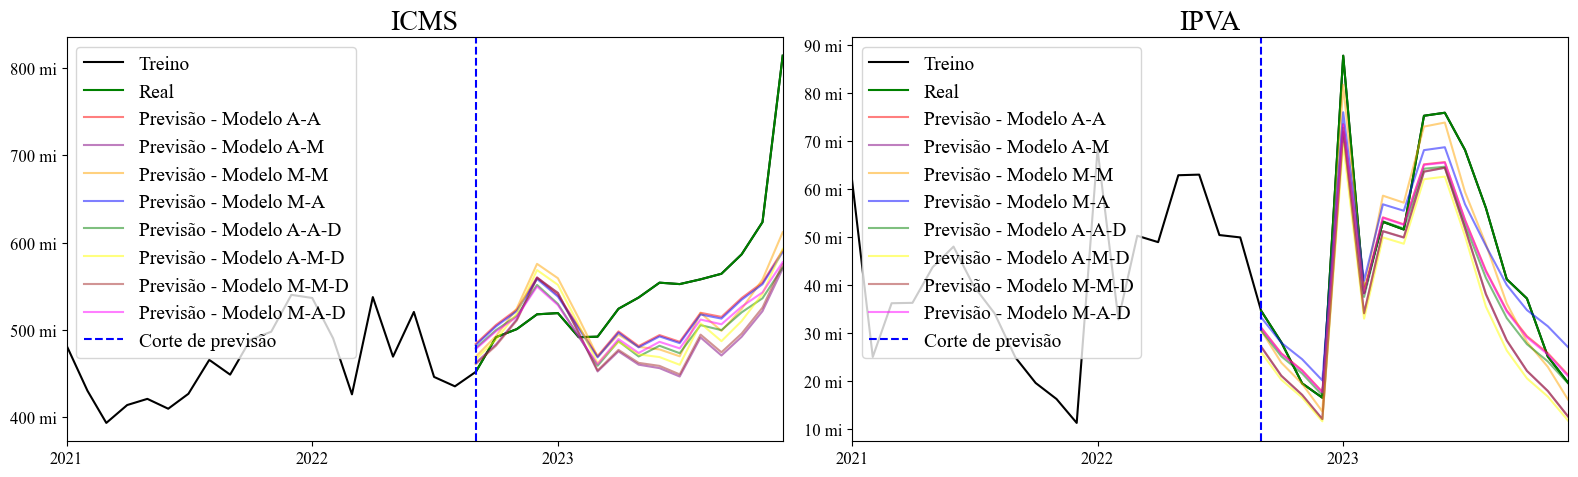

In [47]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Base de dados para os graficos
ini_treino = '2021-01-01'
fim_treino = '2022-08-01'
ini_prev = '2022-09-01'
fim_prev = '2023-12-01'
imp_ax = {'ICMS': [ax1, df_prev_real_icms, "A-A"], 'IPVA': [ax2, df_prev_real_ipva, "M-M"]}
dfs_prev_dict_icms = {"A-A": [ICMS_df_prev_aa, 'red'],
              "A-M": [ICMS_df_prev_am, 'purple'],
              "M-M": [ICMS_df_prev_mm, 'orange'],
              "M-A": [ICMS_df_prev_ma, 'blue'],
              "A-A-D": [ICMS_df_prev_aa_damp, 'green'],
              "A-M-D": [ICMS_df_prev_am_damp, 'yellow'],
              "M-M-D": [ICMS_df_prev_mm_damp, 'brown'],
              "M-A-D": [ICMS_df_prev_ma_damp, 'magenta']
              }
dfs_prev_dict_ipva = {"A-A": [IPVA_df_prev_aa, 'red'],
              "A-M": [IPVA_df_prev_am, 'purple'],
              "M-M": [IPVA_df_prev_mm, 'orange'],
              "M-A": [IPVA_df_prev_ma, 'blue'],
              "A-A-D": [IPVA_df_prev_aa_damp, 'green'],
              "A-M-D": [IPVA_df_prev_am_damp, 'yellow'],
              "M-M-D": [IPVA_df_prev_mm_damp, 'brown'],
              "M-A-D": [IPVA_df_prev_ma_damp, 'magenta']
              }


for imp, axs in imp_ax.items():
  # Treino
  sns.lineplot(x=df.loc[(df.index >= ini_treino) & (df.index <= fim_prev)].index,
               y=df.loc[(df.index >= ini_treino) & (df.index <= fim_prev)][imp],
               label='Treino',
               color='black',
               ax=axs[0])
  # Real
  sns.lineplot(x=df.loc[(df.index >= ini_prev) & (df.index <= fim_prev)].index,
               y=df.loc[(df.index >= ini_prev) & (df.index <= fim_prev)][imp],
               label='Real',
               color='green',
               ax=axs[0])
for mod_nome, mod_df_e_cor in dfs_prev_dict_icms.items():
  # Previsão
  sns.lineplot(x=mod_df_e_cor[0].loc[(mod_df_e_cor[0].index >= ini_prev) & (mod_df_e_cor[0].index <= fim_prev)].index,
              y=mod_df_e_cor[0].loc[(mod_df_e_cor[0].index >= ini_prev) & (mod_df_e_cor[0].index <= fim_prev)]['ICMS'],
              label=f'Previsão - Modelo {mod_nome}',
              color=mod_df_e_cor[1],
              ax=ax1,
              alpha=0.5)
for mod_nome, mod_df_e_cor in dfs_prev_dict_ipva.items():
  # Previsão
  sns.lineplot(x=mod_df_e_cor[0].loc[(mod_df_e_cor[0].index >= ini_prev) & (mod_df_e_cor[0].index <= fim_prev)].index,
            y=mod_df_e_cor[0].loc[(mod_df_e_cor[0].index >= ini_prev) & (mod_df_e_cor[0].index <= fim_prev)]['IPVA'],
            label=f'Previsão - Modelo {mod_nome}',
            color=mod_df_e_cor[1],
            ax=ax2,
            alpha=0.5)


# Formatação
def formatar_milhares(x, pos):
  return f'{x/1000000:.0f} mi'
formatter = mticker.FuncFormatter(formatar_milhares)
year_locator = YearLocator(base=1)

for ax in (ax1, ax2):
  ax.xaxis.set_major_locator(year_locator)
  ax.yaxis.set_major_formatter(formatter)
  ax.set_xlabel('')
  ax.set_ylabel('')
  #ax.spines['top'].set_visible(False)
  #ax.spines['right'].set_visible(False)
  ax.set_xlim(min(df.loc[(df.index >= ini_treino) & (df.index <= fim_prev)].index), max(df.loc[(df.index >= ini_treino) & (df.index <= fim_prev)].index))
  ax.tick_params(axis='x', labelsize=12)
  ax.tick_params(axis='y', labelsize=12)
  ax.axvline(x=pd.to_datetime('2022-09-01'), color='blue', linestyle='--', label='Corte de previsão')
  ax.legend(loc='upper left')
ax1.set_title('ICMS', fontdict={'fontsize': 20})
ax2.set_title('IPVA', fontdict={'fontsize': 20})
plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/Gerência de Estudos e Projeções/ARTIGOS/Artigo HOLT-SARIMA/Resultados/graf_previsoes_TODOS_OS_MODELOS.png', transparent=True, dpi=800)
plt.show()